In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

%matplotlib inline

In [2]:
df = pd.read_csv('train.csv')
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [3]:
df.head(n=10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [4]:
# Count the number of NaN (missing) values
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
df = df.drop(['Cabin', 'Ticket'], axis=1)

In [6]:
# Impute missing age values
def impute(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)

In [7]:
r = re.compile(", (.*?)\.")

def extract_titles(name):
    title = r.search(name)[1]
    title_dict = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"

                    }
    return title_dict[title]

def age_group(age):
    '''
    Divide passengers into age groups
    '''
    if age < 13:
        return 'Child'
    elif age < 17 and age >= 13:
        return "Teen"
    elif age < 60 and age >= 17:
        return "Adult"
    else:
        return "Senior Citizen"

def family_group(fam):
    s, p = fam
    count = s + p

    if count == 0:
        return "Alone"
    elif p == 0 and s == 1:
        return "Couples"
    else:
        return "With Family"

In [8]:
def new_features(df):
    df['Travel Group'] = df[['SibSp', 'Parch']].apply(family_group, axis=1)
    df['Title'] = df['Name'].apply(extract_titles)
    df['Age Group'] = df['Age'].apply(age_group)

In [9]:
impute(df)
new_features(df)

In [22]:
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split, learning_curve, cross_val_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score

In [11]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure(figsize=(12, 8))
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [16]:
def encode_labels(data):
    label_encoder = preprocessing.LabelEncoder()
    data['Sex'] = label_encoder.fit_transform(data['Sex'].astype('str'))
    data['Embarked'] = label_encoder.fit_transform(data['Embarked'].astype('str'))
    data['Title'] = label_encoder.fit_transform(data['Title'].astype('str'))
    data['Travel Group'] = label_encoder.fit_transform(data['Sex'].astype('str'))
    data['Age Group'] = label_encoder.fit_transform(data['Embarked'].astype('str'))
    
encode_labels(df) 

In [93]:
y = df['Survived']
X = df[['Sex', 'Travel Group', 'Title', 'Age Group', 'Embarked']]

# Testing / Training split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [107]:
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
]
clf = GridSearchCV(SVC(), param_grid, cv=5)
clf.fit(X, y)
clf.best_params_

{'C': 1, 'kernel': 'linear'}

In [108]:
clf = SVC(C=1, kernel='linear')
clf.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [109]:
cv_scores = cross_val_score(clf, X, y, cv=5)
cv_scores.sum() / cv_scores.shape[0]

0.78671502492918788

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

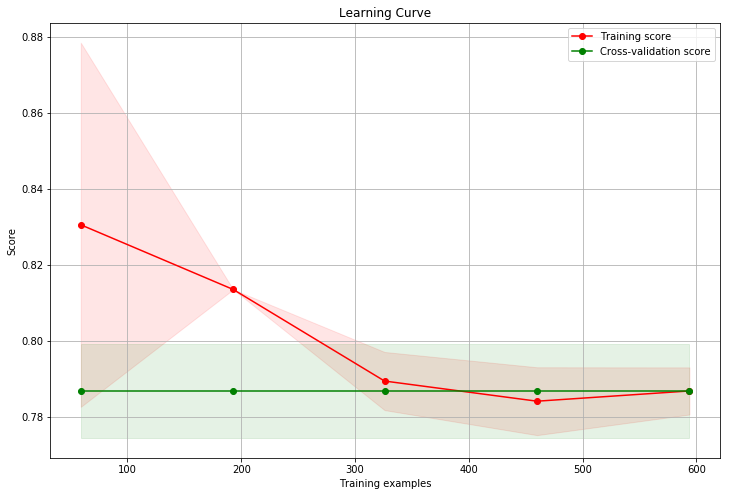

In [110]:
X = df[['Sex', 'Travel Group', 'Title', 'Age Group', 'Embarked']]
plot_learning_curve(clf, "Learning Curve", X.values, y.values)